{% include toc title="In This Chapter" icon="file-text" %}

<div class='notice--success' markdown="1">

## <i class="fa fa-ship" aria-hidden="true"></i> Chapter 13 - NETCDF 4 Climate Data in Open Source Python 

In this chapter, you will learn how to work with Climate Data Sets (MACA v2 for the United states) stored in netcdf 4 format using open source **Python**.

## <i class="fa fa-graduation-cap" aria-hidden="true"></i> Learning Objectives

After completing this chapter, you will be able to:

* Summarize MACA v 2 climate data stored in netcdf 4 format by seasons across all time periods using `xarray`.
* Summarize MACA v 2 climate data stored in netcdf 4 format by seasons and across years using `xarray`.

## <i class="fa fa-check-square-o fa-2" aria-hidden="true"></i> What You Need

You will need a computer with internet access to complete this lesson and ...

</div>

## Calculate Seasonal Averages Using MACA vs Climate Data 

In this lesson, you will learn how to calculate seasonal averages over several years
using MACA v 2 Climate Data downloaded in `netcdf4` format using 
`xarray`.

In this example you will use the forecast temperature data downloaded from the 
northwestknowledge.net website. 

In [1]:
# Make sure ea dir exists - if not create it
import os
import earthpy as et
ea_path = os.path.join(et.io.HOME, 'earth-analytics', 'data')

if not os.path.exists(ea_path):
    os.makedirs(ea_path)

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import geopandas as gpd
import earthpy as et
import xarray as xr
import regionmask

# Plotting options
sns.set(font_scale=1.3)
sns.set_style("white")

# Optional - set your working directory if you wish to use the data
# accessed lower down in this notebook (the USA state boundary data)
os.chdir(os.path.join(et.io.HOME,
                      'earth-analytics',
                      'data'))

To begin, you can download and open up a MACA v2 netcdf file. The file below is a 
projected maximum temperature dataset downscaled using the `BNU-ESM` model for 2006-2099.

In [3]:
# Get netcdf file
data_path_monthly = 'http://thredds.northwestknowledge.net:8080/thredds/dodsC/agg_macav2metdata_tasmax_BNU-ESM_r1i1p1_rcp45_2006_2099_CONUS_monthly.nc'

# Open up the data
with xr.open_dataset(data_path_monthly) as file_nc:
    monthly_forecast_temp_xr = file_nc

# xarray object
monthly_forecast_temp_xr

<xarray.Dataset>
Dimensions:          (crs: 1, lat: 585, lon: 1386, time: 1128)
Coordinates:
  * lat              (lat) float64 25.06 25.1 25.15 25.19 ... 49.31 49.35 49.4
  * crs              (crs) int32 1
  * lon              (lon) float64 235.2 235.3 235.3 235.4 ... 292.9 292.9 292.9
  * time             (time) object 2006-01-15 00:00:00 ... 2099-12-15 00:00:00
Data variables:
    air_temperature  (time, lat, lon) float32 ...
Attributes:
    description:                     Multivariate Adaptive Constructed Analog...
    id:                              MACAv2-METDATA
    naming_authority:                edu.uidaho.reacch
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    Metadata_Link:                   
    cdm_data_type:                   FLOAT
    title:                           Monthly aggregation of downscaled daily ...
    summary:                         This archive contains monthly downscaled...
    keywords:                        monthly, precipitation, maximum temperat...
    keywords_vocabulary:             
    standard_name_vocabulary:        CF-1.0
    history:                         No revisions.
    comment:                         
    geospatial_bounds:               POLYGON((-124.7722 25.0631,-124.7722 49....
    geospatial_lat_min:              25.0631
    geospatial_lat_max:              49.3960
    geospatial_lon_min:              -124.7722
    geospatial_lon_max:              -67.0648
    geospatial_lat_units:            decimal degrees north
    geospatial_lon_units:            decimal degrees east
    geospatial_lat_resolution:       0.0417
    geospatial_lon_resolution:       0.0417
    geospatial_vertical_min:         0.0
    geospatial_vertical_max:         0.0
    geospatial_vertical_resolution:  0.0
    geospatial_vertical_positive:    up
    time_coverage_start:             2091-01-01T00:0
    time_coverage_end:               2095-12-31T00:00
    time_coverage_duration:          P5Y
    time_coverage_resolution:        P1M
    date_created:                    2014-05-15
    date_modified:                   2014-05-15
    date_issued:                     2014-05-15
    creator_name:                    John Abatzoglou
    creator_url:                     http://maca.northwestknowledge.net
    creator_email:                   jabatzoglou@uidaho.edu
    institution:                     University of Idaho
    processing_level:                GRID
    project:                         
    contributor_name:                Katherine C. Hegewisch
    contributor_role:                Postdoctoral Fellow
    publisher_name:                  REACCH
    publisher_email:                 reacch@uidaho.edu
    publisher_url:                   http://www.reacchpna.org/
    license:                         Creative Commons CC0 1.0 Universal Dedic...
    coordinate_system:               WGS84,EPSG:4326

In the example below you subset data for the state of 
California similar to what you did in the previous lesson. You can 
select any state that you wish for this analysis!


In [4]:
# Download natural earth data to generate AOI
et.data.get_data(
    url="https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/50m/cultural/ne_50m_admin_1_states_provinces_lakes.zip")

states_path = "earthpy-downloads/ne_50m_admin_1_states_provinces_lakes"
states_path = os.path.join(
    states_path, "ne_50m_admin_1_states_provinces_lakes.shp")

states_gdf = gpd.read_file(states_path)
cali_aoi = states_gdf[states_gdf.name == "California"]

In [5]:
# Would this be better if it only returned 4 values?? probably so
# Helper Function to extract AOI
def get_aoi(shp, world=True):
    """Takes a geopandas object and converts it to a lat/ lon
    extent """

    lon_lat = {}
    # Get lat min, max
    aoi_lat = [float(shp.total_bounds[1]), float(shp.total_bounds[3])]
    aoi_lon = [float(shp.total_bounds[0]), float(shp.total_bounds[2])]

    # Handle the 0-360 lon values
    if world:
        aoi_lon[0] = aoi_lon[0] + 360
        aoi_lon[1] = aoi_lon[1] + 360
    lon_lat["lon"] = aoi_lon
    lon_lat["lat"] = aoi_lat
    return lon_lat

In [6]:
# Get lat min, max from Cali aoi extent
cali_bounds = get_aoi(cali_aoi)

# Slice by time & aoi location
start_date = "2059-12-15"
end_date = "2099-12-15"

cali_temp = monthly_forecast_temp_xr["air_temperature"].sel(
    time=slice(start_date, end_date),
    lon=slice(cali_bounds["lon"][0], cali_bounds["lon"][1]),
    lat=slice(cali_bounds["lat"][0], cali_bounds["lat"][1]))
cali_temp

<xarray.DataArray 'air_temperature' (time: 481, lat: 227, lon: 246)>
[26860002 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 32.56 32.6 32.65 32.69 ... 41.85 41.9 41.94 41.98
  * lon      (lon) float64 235.6 235.7 235.7 235.8 ... 245.7 245.8 245.8 245.9
  * time     (time) object 2059-12-15 00:00:00 ... 2099-12-15 00:00:00
Attributes:
    long_name:      Monthly Average of Daily Maximum Near-Surface Air Tempera...
    units:          K
    grid_mapping:   crs
    standard_name:  air_temperature
    height:         2 m
    cell_methods:   time: maximum(interval: 24 hours);mean over days
    _ChunkSizes:    [ 10  44 107]

In [7]:
print("Time Period start: ", cali_temp.time.min().values)
print("Time Period end: ", cali_temp.time.max().values)

Time Period start:  2059-12-15 00:00:00
Time Period end:  2099-12-15 00:00:00


In [8]:
# Create the region mask object - this is used to identify each region
# cali_region = regionmask.from_geopandas(cali_aoi,
#                                         names="name",
#                                         name="name",
#                                         abbrevs="iso_3166_2")
cali_mask = regionmask.mask_3D_geopandas(cali_aoi,
                                         monthly_forecast_temp_xr.lon,
                                         monthly_forecast_temp_xr.lat)
# Mask the netcdf data
cali_temp_masked = cali_temp.where(cali_mask)
cali_temp_masked.dims

('time', 'lat', 'lon', 'region')

In [9]:
cali_temp.values.shape

(481, 227, 246)

In [10]:
# Compare mean values for masked vs unmasked
# print(cali_temp.where(pd.notnull(cali_temp)).mean())

# print(cali_temp_masked.mean())

Calculate the mean temperature for each season across the entire dataset. 
This will produce 4 arrays - one representing mean temperature for each seasons. 

In [11]:
cali_season_summary = cali_temp_masked.groupby(
    'time.season').mean('time', skipna=True)

# This will create 4 arrays - one for each season showing mean temperature values
cali_season_summary.shape

(4, 227, 246, 1)

Plot the seasonal data.

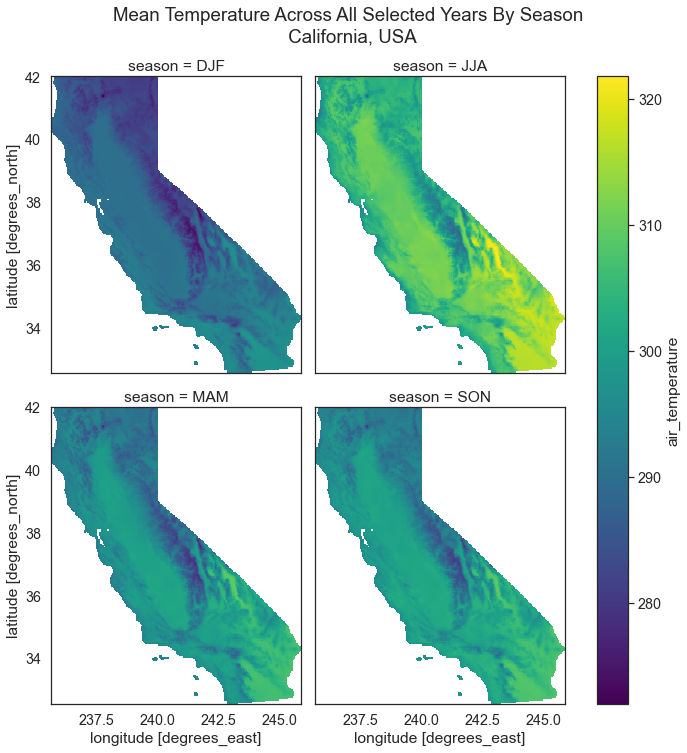

In [12]:
# Create a plot showing mean temperature aross seasons
cali_season_summary.plot(col='season', col_wrap=2, figsize=(10, 10))
plt.suptitle("Mean Temperature Across All Selected Years By Season \n California, USA",
             y=1.05)

plt.show()

## Calculate UnWeighted Seasonal Averages For By Season Across Each Year

Above you created one single value per season which summarized seasonal data across all years.
However you may want to look at seasonal variation year to year in the projected data.
You can calculate seasonal statistcs by 

1. resampling the data and then
2. grouping the data and summarizing it

In [13]:
# Resample the data by season across all years
cali_season_mean_all_years = cali_temp_masked.resample(
    time='QS-DEC', keep_attrs=True).mean()
cali_season_mean_all_years.shape

(161, 227, 246, 1)

In [14]:
# Summarize each array into one single (mean) value
cali_seasonal_mean = cali_season_mean_all_years.groupby('time').mean([
    "lat", "lon"])
cali_seasonal_mean.shape

(161, 1)

In [15]:
# This data now has one value per season rather than an array
cali_seasonal_mean.shape

(161, 1)

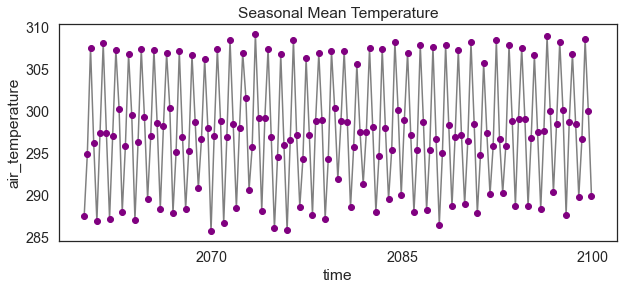

In [16]:
# Plot the data
f, ax = plt.subplots(figsize=(10, 4))
cali_seasonal_mean.plot(marker="o",
                        color="grey",
                        markerfacecolor="purple",
                        markeredgecolor="purple")
ax.set(title="Seasonal Mean Temperature")
plt.show()

### Export Seasonal Climate Project Data To .csv File
At this point you can convert the data to a dataframe and export 
it to a `.csv` format if you wish.

In [17]:
# Convert to a dataframe
cali_seasonal_mean_df = cali_seasonal_mean.to_dataframe()
cali_seasonal_mean_df

,,air_temperature
time,region,
2059-12-01 00:00:00,53,287.588531
2060-03-01 00:00:00,53,294.914917
2060-06-01 00:00:00,53,307.549652
2060-09-01 00:00:00,53,296.199188
2060-12-01 00:00:00,53,286.922699
...,...,...
2098-12-01 00:00:00,53,289.853882
2099-03-01 00:00:00,53,296.710419
2099-06-01 00:00:00,53,308.563416


In [18]:
# Export a csv file
cali_seasonal_mean_df.to_csv("cali-seasonal-temp.csv")

### Plot Seasonal Data By Season 

Using `groupby()` you can group the data and plot it by season to better look at seasonal trends. 

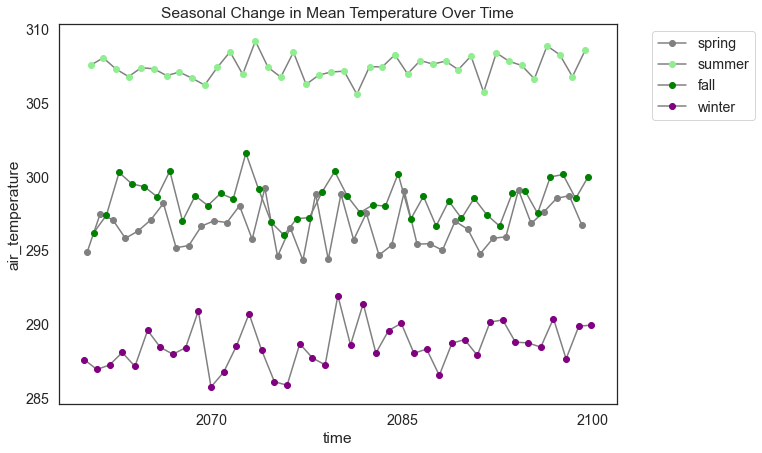

In [19]:
colors = {3: "grey", 6: "lightgreen", 9: "green", 12: "purple"}
seasons = {3: "spring", 6: "summer", 9: "fall", 12: "winter"}

f, ax = plt.subplots(figsize=(10, 7))
for month, arr in cali_seasonal_mean.groupby('time.month'):
    arr.plot(ax=ax,
             color="grey",
             marker="o",
             markerfacecolor=colors[month],
             markeredgecolor=colors[month],
             label=seasons[month])

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set(title="Seasonal Change in Mean Temperature Over Time")
plt.show()

## Weighted Summary by Season

To begin, you will generate a list of days in each month which will be used to weight
your seasonal summary data according to the the days in each month. 

* TODO -- redo this section to use the approach above which is perfect

In [20]:
# Calculate seasonal averages
# http://xarray.pydata.org/en/stable/examples/monthly-means.html

month_length = cali_temp_masked.time.dt.days_in_month
month_length

<xarray.DataArray 'days_in_month' (time: 481)>
array([31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30,
       31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30,
       31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28,
       31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31,
       31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31,
       31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31,
       30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31,
       30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31,
       30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31,
       30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31,
       28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30,
       31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30,
       31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30,
       31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30,
       31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28,
       31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31,
       31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31,
       31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31,
       30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31,
       30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31,
       30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31,
       30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31,
       28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30,
       31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30,
       31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30,
       31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30,
       31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28,
       31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31,
       31, 30, 31, 30, 31])
Coordinates:
  * time     (time) object 2059-12-15 00:00:00 ... 2099-12-15 00:00:00

Next, divide the data grouped by season by the total days represented
in each season to create weighted values

In [21]:
# https://stackoverflow.com/questions/59234745/is-there-any-easy-where-way-to-compute-seasonal-mean-with-xarray

In [22]:
# This is returning values of 0 rather than na
# Calculate a weighted mean by season
cali_weighted_mean = ((cali_temp * month_length).resample(time='QS-DEC').sum() /
                      month_length.resample(time='QS-DEC').sum())
# Replace 0 values with nan
cali_weighted_mean = cali_weighted_mean.where(cali_weighted_mean)
cali_weighted_mean.shape

(161, 227, 246)

In [23]:
cali_weighted_season_value = cali_weighted_mean.groupby('time').mean([
    "lat", "lon"])
cali_weighted_season_value.shape

(161,)

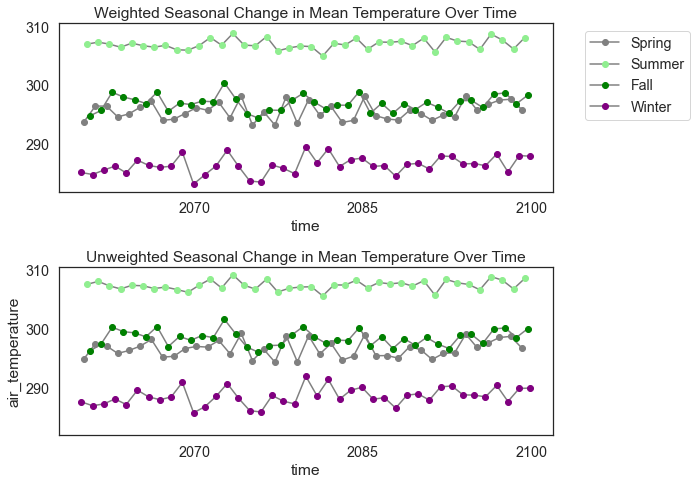

In [24]:
colors = {3: "grey", 6: "lightgreen", 9: "green", 12: "purple"}
seasons = {3: "Spring", 6: "Summer", 9: "Fall", 12: "Winter"}

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), sharey=True)
for month, arr in cali_weighted_season_value.groupby('time.month'):
    arr.plot(ax=ax1,
             color="grey",
             marker="o",
             markerfacecolor=colors[month],
             markeredgecolor=colors[month],
             label=seasons[month])

ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.set(title="Weighted Seasonal Change in Mean Temperature Over Time")

for month, arr in cali_seasonal_mean.groupby('time.month'):
    arr.plot(ax=ax2,
             color="grey",
             marker="o",
             markerfacecolor=colors[month],
             markeredgecolor=colors[month],
             label=seasons[month])

ax2.set(title="Unweighted Seasonal Change in Mean Temperature Over Time")
f.tight_layout()
plt.show()

If you want, you can compare the difference between weighted vs unweighted 
values.

In [25]:
# What does the difference look like weighted vs unweighted?
cali_seasonal_mean - cali_weighted_season_value

<xarray.DataArray (time: 161, region: 1)>
array([[2.42445398],
       [1.1149551 ],
       [0.56349408],
       [1.41986191],
       [2.10024405],
       [0.99747663],
       [0.74377694],
       [1.67514298],
       [1.65447404],
       [0.6276056 ],
       [0.30815426],
       [1.46946358],
       [1.82464189],
       [1.19897048],
       [0.32238954],
       [1.51911652],
       [2.03105749],
       [1.18102475],
       [0.23554512],
       [1.7812482 ],
...
       [1.04313289],
       [0.54936444],
       [1.29146021],
       [2.11720145],
       [0.86377328],
       [0.17050946],
       [1.50163027],
       [2.07188164],
       [1.04584555],
       [0.58235629],
       [1.44673595],
       [2.39297506],
       [1.09318667],
       [0.62666739],
       [1.67848387],
       [1.81829381],
       [0.85855153],
       [0.46202606],
       [1.72129072],
       [1.99271339]])
Coordinates:
  * time     (time) object 2059-12-01 00:00:00 ... 2099-12-01 00:00:00
  * region   (region) int64 53

## The Same Analysis for the West Coast

Above you calculate seasonal summaries for the state of California. You can 
implement the same analysis for each aoi region in a shapefile if you want 
following the workflow that you learned in the previous lesson. 

In [26]:
# Create AOI Subset
cali_or_wash_nev = states_gdf[states_gdf.name.isin(
    ["California", "Oregon", "Washington", "Nevada"])]
west_bounds = get_aoi(cali_or_wash_nev)

# Create the mask
west_mask = regionmask.mask_3D_geopandas(cali_or_wash_nev,
                                         monthly_forecast_temp_xr.lon,
                                         monthly_forecast_temp_xr.lat)


# Slice by time & aoi location
start_date = "2059-12-15"
end_date = "2099-12-15"

west_temp = monthly_forecast_temp_xr["air_temperature"].sel(
    time=slice(start_date, end_date),
    lon=slice(west_bounds["lon"][0], west_bounds["lon"][1]),
    lat=slice(west_bounds["lat"][0], west_bounds["lat"][1]))

# Apply the mask
west_temp_masked = west_temp.where(west_mask)
west_temp_masked
# Resample the data by season across all years
#west_season_mean_all_years = west_temp_masked.groupby('region').resample(time='QS-DEC', keep_attrs=True).mean()
# cali_seasonal_mean = cali_season_mean_all_years.groupby('time').mean(["lat", "lon"])
# cali_seasonal_mean

<xarray.DataArray 'air_temperature' (time: 481, lat: 395, lon: 256, region: 4)>
array([[[[nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         ...,
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan]],

        [[nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         ...,
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan]],

        [[nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan]],

        [[nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         ...,
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan]],

        [[nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         ...,
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan]]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 32.56 32.6 32.65 32.69 ... 48.85 48.9 48.94 48.98
  * lon      (lon) float64 235.3 235.4 235.4 235.4 ... 245.8 245.9 245.9 245.9
  * time     (time) object 2059-12-15 00:00:00 ... 2099-12-15 00:00:00
  * region   (region) int64 53 82 86 96
Attributes:
    long_name:      Monthly Average of Daily Maximum Near-Surface Air Tempera...
    units:          K
    grid_mapping:   crs
    standard_name:  air_temperature
    height:         2 m
    cell_methods:   time: maximum(interval: 24 hours);mean over days
    _ChunkSizes:    [ 10  44 107]

In [27]:
# This produces a raster for each season over time across regions
west_coast_mean_temp_raster = west_temp_masked.resample(
    time='QS-DEC', keep_attrs=True).mean()
west_coast_mean_temp_raster.shape

(161, 395, 256, 4)

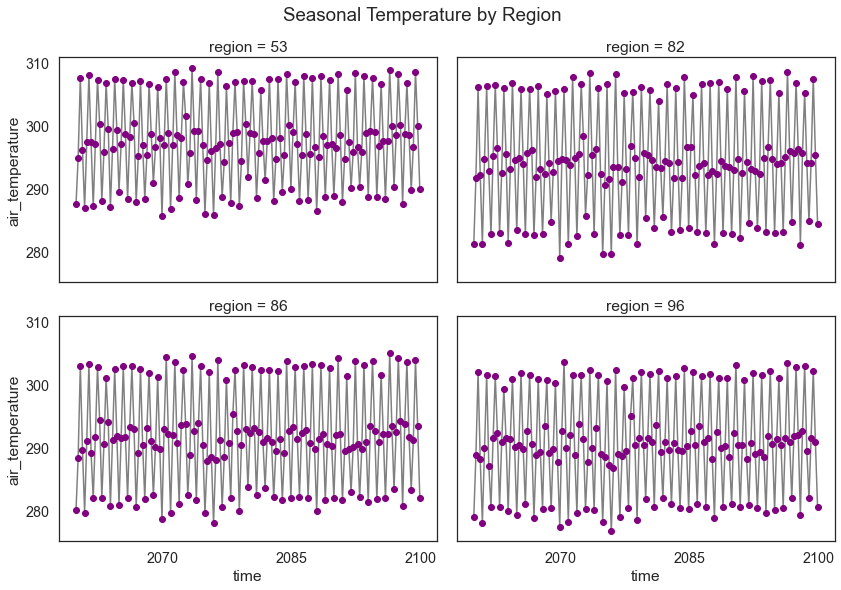

In [28]:
# This produces a regional summary
regional_summary = west_coast_mean_temp_raster.groupby('time').mean([
    "lat", "lon"])
regional_summary.plot(col="region",
                      marker="o",
                      color="grey",
                      markerfacecolor="purple",
                      markeredgecolor="purple",
                      col_wrap=2,
                      figsize=(12, 8))

plt.suptitle("Seasonal Temperature by Region", y=1.03)
plt.show()

In [29]:
# The data can then be easily converted to a dataframe
regional_summary.to_dataframe()

air_temperature
time                region                 
2059-12-01 00:00:00 53           287.588531
                    82           281.238739
                    86           280.193787
                    96           279.038940
2060-03-01 00:00:00 53           294.914886
...                                     ...
2099-09-01 00:00:00 96           290.840363
2099-12-01 00:00:00 53           289.929504
                    82           284.486908
                    86           282.051971
                    96           280.577484

[644 rows x 1 columns]